In [51]:
import gym
from gym import spaces
import numpy as np
import random
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import ReplayBuffer

from models import DQNAgent, CentralizedDQNAgent, MADDPGAgent, MAPPOAgent

In [52]:
class SequentialBargainingEnv(gym.Env):
    def __init__(self, grid_size=10, delta=0.9, max_rounds=5):
        super().__init__()
        self.n_agents = 2
        self.grid_size = grid_size
        self.delta = delta
        self.max_rounds = max_rounds
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)
        self.propose_space = spaces.Discrete(grid_size + 1)
        self.accept_space = spaces.Discrete(2)

    def reset(self):
        self.pie = 1.0
        self.round = 0
        self.turn = 0
        self.last_offer = 0.5
        self.terminal = False
        return [self._make_obs(i) for i in range(self.n_agents)]

    # each agent's observation space consists of the current pie, the previous offer, and whether it is their turn
    def _make_obs(self, agent):
        return np.array([self.pie, self.last_offer, float(self.turn == agent)], dtype=np.float32)

    def step(self, actions):
        assert not self.terminal, "Episode ended, call reset()"
        proposer = self.turn
        responder = 1 - proposer
        prop_val = actions[proposer] / self.grid_size * self.pie
        self.last_offer = prop_val
        accept = actions[responder]
        self.round += 1
        # if ome agent accepted, terminate and read rewards
        if accept == 1 or self.round >= self.max_rounds:
            self.terminal = True
            final_pie = self.pie * (self.delta ** (0 if accept==1 else 1))
            share_prop = (prop_val if accept==1 else final_pie * (prop_val/self.pie))
            share_resp = final_pie - share_prop
            rewards = [0.0, 0.0]
            rewards[proposer] = share_prop
            rewards[responder] = share_resp
            dones = [True, True]
            return [self._make_obs(i) for i in range(self.n_agents)], rewards, dones, {}
        # otherwise neither earns reward, continue game
        else:
            self.pie *= self.delta
            self.turn = responder
            rewards = [0.0, 0.0]
            dones = [False, False]
            return [self._make_obs(i) for i in range(self.n_agents)], rewards, dones, {}

In [53]:
def train(env, agents, episodes=1000, eps_start=1.0, eps_final=0.01, eps_decay=500):
    obs_dim = env.observation_space.shape[0]
    act_dim = env.propose_space.n
    episode_rewards = np.zeros((episodes, env.n_agents))
    window = 100
    for ep in range(episodes):
        obs = env.reset()
        done = False
        eps = eps_final + (eps_start - eps_final) * np.exp(-1. * ep/eps_decay)
        rewards_this_ep = np.zeros(env.n_agents)
        while not done:
            actions = [None, None]
            was_proposer = [env.turn == i for i in range(env.n_agents)]
            for i, agent in enumerate(agents):
                actions[i] = agent.select(obs[i], eps, was_proposer[i])
            next_obs, rewards, dones, _ = env.step(actions)
            rewards_this_ep += rewards
            for i, agent in enumerate(agents):
                agent.store(obs[i], actions[i], rewards[i], next_obs[i], dones[i], was_proposer[i])
                agent.update()
            obs = next_obs
            done = all(dones)
        episode_rewards[ep] = rewards_this_ep
            
        if ep % 100 == 0:
            print(f"Episode {ep} complete")
            
    return episode_rewards

In [54]:
def train_centralized(env, agent, episodes=2000, eps_start=1.0, eps_final=0.05, eps_decay=1000):
    obs_dim = env.observation_space.shape[0]
    act_dim = env.propose_space.n
    episode_rewards = np.zeros((episodes, env.n_agents))
    window = 100

    for ep in range(episodes):
        obs = env.reset()
        done = False
        eps = eps_final + (eps_start - eps_final) * np.exp(-1. * ep / eps_decay)
        rewards_this_ep = np.zeros(env.n_agents)
        while not done:
            actions = agent.select(obs, eps)
            next_obs, rewards, dones, _ = env.step(actions)
            rewards_this_ep += rewards
            agent.store(obs, actions, rewards, next_obs, dones)
            agent.update()
            obs = next_obs
            done = all(dones)
        episode_rewards[ep] = rewards_this_ep
            
        if ep % 100 == 0:
            print(f"Episode {ep} complete")
            
    return episode_rewards

In [55]:
def train_mappo(env, agents, buffer, episodes=2000, batch_size=128, gamma=0.95, tau=0.95, eps_start=1.0, eps_end=0.05, eps_decay=1000):
    obs_dim = env.observation_space.shape[0]
    act_dim = env.propose_space.n
    eps = eps_start
    
    episode_rewards = np.zeros((episodes, env.n_agents))
    window = 100

    for ep in range(episodes):
        obs = env.reset()
        done = False
        rewards_this_ep = np.zeros(env.n_agents)

        while not done:
            actions = [agents[i].select(obs[i], eps) for i in range(env.n_agents)]
            next_obs, rewards, dones, _ = env.step(actions)
            rewards_this_ep += rewards
            buffer.push(obs, actions, rewards, next_obs, dones)
            obs = next_obs
            done = all(dones)

            if len(buffer) < batch_size:
                continue

            batch = buffer.sample(batch_size)
            obs_b, act_b, rew_b, next_obs_b, done_b = batch
            obs_b = torch.tensor(obs_b, dtype=torch.float32)
            act_b = torch.tensor(act_b, dtype=torch.int64)
            rew_b = torch.tensor(rew_b, dtype=torch.float32)
            next_obs_b = torch.tensor(next_obs_b, dtype=torch.float32)
            done_b = torch.tensor(done_b, dtype=torch.float32)

            full_obs = obs_b.view(batch_size, -1)
            next_full_obs = next_obs_b.view(batch_size, -1)

            for i, agent in enumerate(agents):
                values = agent.critic(full_obs).squeeze(-1)
                next_values = agent.critic(next_full_obs).squeeze(-1).detach()
                targets = rew_b.sum(dim=1) + gamma * next_values * (1 - done_b[:, 0])

                critic_loss = F.mse_loss(values, targets)
                agent.critic_opt.zero_grad()
                critic_loss.backward()
                agent.critic_opt.step()

                logits = agent.actor(obs_b[:, i, :])
                probs = F.softmax(logits, dim=1)
                probs = probs / probs.sum(dim=1, keepdim=True)
                dist = torch.distributions.Categorical(probs)
                log_probs = dist.log_prob(act_b[:, i])

                with torch.no_grad():
                    advantage = targets - values

                ratio = torch.exp(log_probs - log_probs.detach())
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1.0 - agent.clip_param, 1.0 + agent.clip_param) * advantage
                actor_loss = -torch.min(surr1, surr2).mean()

                agent.actor_opt.zero_grad()
                actor_loss.backward()
                agent.actor_opt.step()

        eps = max(eps_end, eps * np.exp(-1. / eps_decay))

        episode_rewards[ep] = rewards_this_ep
            
        if ep % 100 == 0:
            print(f"Episode {ep} complete")
            
    return episode_rewards

In [56]:
def train_maddpg(env, agents, buffer, episodes=1000, batch_size=128, gamma=0.95, tau=0.01, noise=0.1):
    obs_dim = env.observation_space.shape[0]
    act_dim = env.propose_space.n
    episode_rewards = np.zeros((episodes, env.n_agents))
    window = 100

    for ep in range(episodes):
        obs = env.reset()
        done = False
        rewards_this_ep = np.zeros(env.n_agents)

        while not done:
            actions = [agents[i].select(obs[i], noise) for i in range(env.n_agents)]
            next_obs, rewards, dones, _ = env.step(actions)
            rewards_this_ep += rewards
            onehot_actions = []
            for i in range(env.n_agents):
                act_vec = np.zeros(act_dim, dtype=np.float32)
                act_vec[actions[i]] = 1.0
                onehot_actions.append(act_vec)
            buffer.push(obs, onehot_actions, rewards, next_obs, dones)
            obs = next_obs
            done = all(dones)

            if len(buffer) < batch_size:
                continue

            batch = buffer.sample(batch_size)
            obs_b, act_b, rew_b, next_obs_b, done_b = batch
            obs_b = torch.tensor(obs_b, dtype=torch.float32)
            act_b = torch.tensor(act_b, dtype=torch.float32)
            rew_b = torch.tensor(rew_b, dtype=torch.float32)
            next_obs_b = torch.tensor(next_obs_b, dtype=torch.float32)
            done_b = torch.tensor(done_b, dtype=torch.float32)

            full_obs = obs_b.view(batch_size, -1)
            full_acts = act_b.view(batch_size, -1)

            temperature = 0.1 + 0.9 * (1 - ep/episodes)
            for i, agent in enumerate(agents):
                next_actions = torch.cat([
                    F.gumbel_softmax(agents[j].target_actor(next_obs_b[:, j, :]), tau=temperature, hard=False)
                    for j in range(env.n_agents)
                ], dim=1)
                next_q = agent.target_critic(next_obs_b.view(batch_size, -1), next_actions)
                target_q = rew_b[:,i].unsqueeze(1) + gamma * next_q * (1 - done_b[:,i].unsqueeze(1))

                curr_q = agent.critic(full_obs, full_acts)
                critic_loss = F.mse_loss(curr_q, target_q.detach())

                agent.critic_opt.zero_grad()
                critic_loss.backward()
                agent.critic_opt.step()

                curr_actions = full_acts.clone()
                curr_actions[:, i*act_dim:(i+1)*act_dim] = F.gumbel_softmax(agents[i].actor(obs_b[:, i, :]), tau=temperature, hard=False)
                actor_loss = -agent.critic(full_obs, curr_actions).mean()

                agent.actor_opt.zero_grad()
                actor_loss.backward()
                agent.actor_opt.step()

                for param, target_param in zip(agent.critic.parameters(), agent.target_critic.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                for param, target_param in zip(agent.actor.parameters(), agent.target_actor.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        episode_rewards[ep] = rewards_this_ep
            
        if ep % 100 == 0:
            print(f"Episode {ep} complete")
            
    return episode_rewards

In [57]:
def evaluate(env, agents, episodes=500):
    total_share_a = 0.0
    for _ in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            actions = [None, None]
            was_proposer = [env.turn == i for i in range(env.n_agents)]
            for i, agent in enumerate(agents):
                actions[i] = agent.select(obs[i], 0.0, was_proposer[i])
            next_obs, rewards, dones, _ = env.step(actions)
            obs = next_obs
            done = all(dones)
        total_share_a += rewards[0]
    return total_share_a / episodes

In [58]:
def evaluate_centralized(env, agent, episodes=500):
    total_share_a = 0.0
    for _ in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            actions = agent.select(obs, eps=0.0)
            next_obs, rewards, dones, _ = env.step(actions)
            obs = next_obs
            done = all(dones)
        total_share_a += rewards[0]
    avg_share_a = total_share_a / episodes
    return avg_share_a

In [59]:
def evaluate_mappo(env, agents, episodes=500):
    total_share_a = 0.0
    for _ in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            actions = [agents[i].select(obs[i], eps=0.0) for i in range(env.n_agents)]
            next_obs, rewards, dones, _ = env.step(actions)
            obs = next_obs
            done = all(dones)
        total_share_a += rewards[0]
    avg_share_a = total_share_a / episodes
    return avg_share_a

In [60]:
def evaluate_maddpg(env, agents, episodes=500):
    total_share_a = 0.0
    for _ in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            actions = [agents[i].select(obs[i], eps=0.0) for i in range(env.n_agents)]
            next_obs, rewards, dones, _ = env.step(actions)
            obs = next_obs
            done = all(dones)
        total_share_a += rewards[0]
    avg_share_a = total_share_a / episodes
    return avg_share_a

In [61]:
expt_grid_size = 5000
expt_delta = 0.9
expt_max_rounds = 10

In [62]:
env = SequentialBargainingEnv(grid_size=expt_grid_size, delta=expt_delta, max_rounds=expt_max_rounds)

obs_dim = env.observation_space.shape[0]
act_dim = env.propose_space.n

agent = CentralizedDQNAgent(obs_dim=obs_dim, act_dim=act_dim, n_agents=2)

output_cdqn = train_centralized(env, agent, episodes=5000)
avg_share = evaluate_centralized(env, agent, episodes=500)
x_star = (1 - env.delta) / (1 - env.delta**2)

print(f"Learned avg share for A: {avg_share:.3f}")
print(f"Theoretical eq share for A: {x_star:.3f}")

Episode 0 complete
Episode 100 complete
Episode 200 complete
Episode 300 complete
Episode 400 complete
Episode 500 complete
Episode 600 complete
Episode 700 complete
Episode 800 complete
Episode 900 complete
Episode 1000 complete
Episode 1100 complete
Episode 1200 complete
Episode 1300 complete
Episode 1400 complete
Episode 1500 complete
Episode 1600 complete
Episode 1700 complete
Episode 1800 complete
Episode 1900 complete
Episode 2000 complete
Episode 2100 complete
Episode 2200 complete
Episode 2300 complete
Episode 2400 complete
Episode 2500 complete
Episode 2600 complete
Episode 2700 complete
Episode 2800 complete
Episode 2900 complete
Episode 3000 complete
Episode 3100 complete
Episode 3200 complete
Episode 3300 complete
Episode 3400 complete
Episode 3500 complete
Episode 3600 complete
Episode 3700 complete
Episode 3800 complete
Episode 3900 complete
Episode 4000 complete
Episode 4100 complete
Episode 4200 complete
Episode 4300 complete
Episode 4400 complete
Episode 4500 complete


In [63]:
env = SequentialBargainingEnv(grid_size=expt_grid_size, delta=expt_delta, max_rounds=expt_max_rounds)
agents = [DQNAgent(obs_dim=3, propose_dim=env.grid_size+1,
                    accept_dim=2) for _ in range(env.n_agents)]
output_idqn = train(env, agents, episodes=5000)
avg_learned = evaluate(env, agents, episodes=500)
x_star = (1 - env.delta) / (1 - env.delta**2)

print(f"Learned avg share for A: {avg_learned:.3f}")
print(f"Theoretical eq share for A: {x_star:.3f}")

Episode 0 complete
Episode 100 complete
Episode 200 complete
Episode 300 complete
Episode 400 complete
Episode 500 complete
Episode 600 complete
Episode 700 complete
Episode 800 complete
Episode 900 complete
Episode 1000 complete
Episode 1100 complete
Episode 1200 complete
Episode 1300 complete
Episode 1400 complete
Episode 1500 complete
Episode 1600 complete
Episode 1700 complete
Episode 1800 complete
Episode 1900 complete
Episode 2000 complete
Episode 2100 complete
Episode 2200 complete
Episode 2300 complete
Episode 2400 complete
Episode 2500 complete
Episode 2600 complete
Episode 2700 complete
Episode 2800 complete
Episode 2900 complete
Episode 3000 complete
Episode 3100 complete
Episode 3200 complete
Episode 3300 complete
Episode 3400 complete
Episode 3500 complete
Episode 3600 complete
Episode 3700 complete
Episode 3800 complete
Episode 3900 complete
Episode 4000 complete
Episode 4100 complete
Episode 4200 complete
Episode 4300 complete
Episode 4400 complete
Episode 4500 complete


In [64]:
env = SequentialBargainingEnv(grid_size=expt_grid_size, delta=expt_delta, max_rounds=expt_max_rounds)

obs_dim = env.observation_space.shape[0]
act_dim = env.propose_space.n

full_obs_dim = env.n_agents * obs_dim

agents = [MAPPOAgent(obs_dim=obs_dim, act_dim=act_dim, full_obs_dim=full_obs_dim) for _ in range(env.n_agents)]
buffer = ReplayBuffer()

output_mappo = train_mappo(env, agents, buffer, episodes=5000)
avg_share = evaluate_mappo(env, agents, episodes=500)
x_star = (1 - env.delta) / (1 - env.delta**2)

print(f"Learned avg share for A: {avg_share:.3f}")
print(f"Theoretical eq share for A: {x_star:.3f}")

Episode 0 complete
Episode 100 complete
Episode 200 complete
Episode 300 complete
Episode 400 complete
Episode 500 complete
Episode 600 complete
Episode 700 complete
Episode 800 complete
Episode 900 complete
Episode 1000 complete
Episode 1100 complete
Episode 1200 complete
Episode 1300 complete
Episode 1400 complete
Episode 1500 complete
Episode 1600 complete
Episode 1700 complete
Episode 1800 complete
Episode 1900 complete
Episode 2000 complete
Episode 2100 complete
Episode 2200 complete
Episode 2300 complete
Episode 2400 complete
Episode 2500 complete
Episode 2600 complete
Episode 2700 complete
Episode 2800 complete
Episode 2900 complete
Episode 3000 complete
Episode 3100 complete
Episode 3200 complete
Episode 3300 complete
Episode 3400 complete
Episode 3500 complete
Episode 3600 complete
Episode 3700 complete
Episode 3800 complete
Episode 3900 complete
Episode 4000 complete
Episode 4100 complete
Episode 4200 complete
Episode 4300 complete
Episode 4400 complete
Episode 4500 complete


In [65]:
env = SequentialBargainingEnv(grid_size=expt_grid_size, delta=expt_delta, max_rounds=expt_max_rounds)
buffer = ReplayBuffer(max_size=100000)

obs_dim = env.observation_space.shape[0]
act_dim_prop = env.propose_space.n
act_dim_resp = env.accept_space.n
act_dim = max(act_dim_prop, act_dim_resp)

full_obs_dim = env.n_agents * obs_dim
full_act_dim = env.n_agents * act_dim

agents = [MADDPGAgent(obs_dim=obs_dim, act_dim=act_dim, full_obs_dim=full_obs_dim, full_act_dim=full_act_dim) for _ in range(env.n_agents)]

output_maddpg = train_maddpg(env, agents, buffer, episodes=5000, batch_size=128, gamma=0.95, tau=0.01, noise=0.2)
avg_share = evaluate_maddpg(env, agents, episodes=500)
x_star = (1 - env.delta) / (1 - env.delta**2)

print(f"Learned avg share for A: {avg_share:.3f}")
print(f"Theoretical eq share for A: {x_star:.3f}")

Episode 0 complete
Episode 100 complete
Episode 200 complete
Episode 300 complete
Episode 400 complete
Episode 500 complete
Episode 600 complete
Episode 700 complete
Episode 800 complete
Episode 900 complete
Episode 1000 complete
Episode 1100 complete
Episode 1200 complete
Episode 1300 complete
Episode 1400 complete
Episode 1500 complete
Episode 1600 complete
Episode 1700 complete
Episode 1800 complete
Episode 1900 complete
Episode 2000 complete
Episode 2100 complete
Episode 2200 complete
Episode 2300 complete
Episode 2400 complete
Episode 2500 complete
Episode 2600 complete
Episode 2700 complete
Episode 2800 complete
Episode 2900 complete
Episode 3000 complete
Episode 3100 complete
Episode 3200 complete
Episode 3300 complete
Episode 3400 complete
Episode 3500 complete
Episode 3600 complete
Episode 3700 complete
Episode 3800 complete
Episode 3900 complete
Episode 4000 complete
Episode 4100 complete
Episode 4200 complete
Episode 4300 complete
Episode 4400 complete
Episode 4500 complete


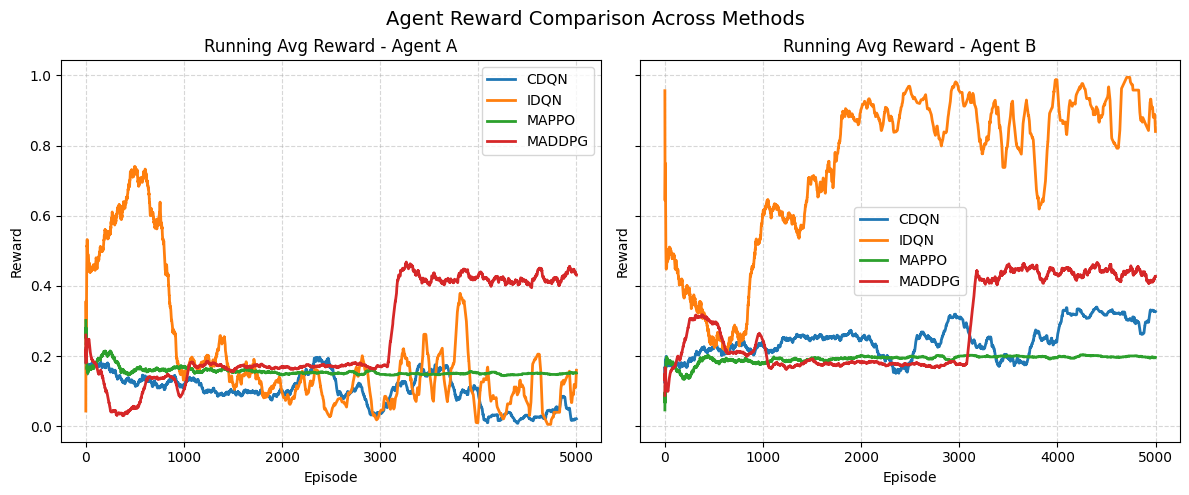

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def running_avg(x, window=50):
    return np.array([
        np.mean(x[max(0, i - window + 1):i + 1]) for i in range(len(x))
    ])

methods = {
    'CDQN': output_cdqn,
    'IDQN': output_idqn,
    'MAPPO': output_mappo,
    'MADDPG': output_maddpg
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
agent_labels = ['Agent A', 'Agent B']
window = 100

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for agent_idx in [0, 1]:
    ax = axs[agent_idx]
    for i, (method_name, rewards) in enumerate(methods.items()):
        avg_rewards = running_avg(rewards[:, agent_idx], window=window)
        ax.plot(avg_rewards, label=method_name, color=colors[i], lw=2)
    ax.set_title(f'Running Avg Reward - {agent_labels[agent_idx]}')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.suptitle('Agent Reward Comparison Across Methods', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("env1_rewards.png")
plt.show()
